In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

### Cargamos el dataset

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df['Pclass'] = df.Pclass.astype(object)

Eliminamos las columnas que no son predicturas

In [4]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Creamos cageogoricas

In [5]:
df = pd.get_dummies(df, drop_first=True)

In [6]:
df['Age'] = df['Age'].fillna(df.Age.mean())


### Crea una regresion logistica

In [7]:
target = 'Survived'
X = df.drop(target, axis = 1)
y = df[target]

model = linear_model.LogisticRegression().fit(X,y)
probabilities = model.predict_proba(X)

p1 = [i[1] for i in probabilities]

### Concepto odds

Mi equipo gana 1 a 4


In [8]:
1/4

0.25

Probabilidad de ganar 

In [9]:
1/(1+4)

0.2

Probabilidad perder

In [10]:
1 - 1/(1+4)

0.8

Mi equipo gana 5 a 3

In [11]:
5/3

1.6666666666666667

Probabilidad que equipo gane 

In [12]:
5/ (5+3)

0.625

Probabilidd de perder

In [13]:
1- (5 / (5+3))

0.375

¿Qué pasa si divido la probabilidad de ganar entre la probabiliad de perder?

In [14]:
p = (5 / (5+3))

p / (1-p)

1.6666666666666667

$$odds = \frac{p}{1-p}$$

Calcula los odds de las predicciones del modelo

In [15]:
odds_titanic = [i / (1-i) for i in p1]

Los odds pueden llegar a ser muy volatiles, pon el histograma

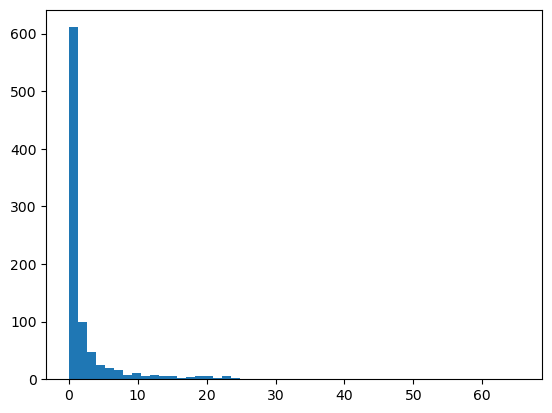

In [16]:
plt.hist(odds_titanic, bins = 50)
plt.show()

$$log(odds) = log(\frac{p}{1-p})$$

Pero el log odds no es tan disperso, histograma del log odds

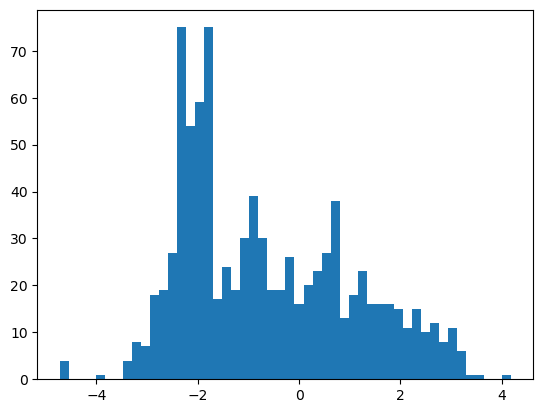

In [17]:
log_odds_titanic = np.log(odds_titanic)

plt.hist(log_odds_titanic, bins = 50)
plt.show()

### ¿Y esto que? 

Si tomamos los coeficientes de una regresión logistica como si gura una regresión lineal, obtenemos un numero extraño

$$z = \Theta ^T X $$



In [18]:
# Calcula Z
z = (model.coef_ * X).sum(axis = 1) + model.intercept_

Resulta ser que z es lo mismo que log odds

In [19]:
verdad = pd.DataFrame({
    'z': z,
    'log_odds': log_odds_titanic
})

verdad.head()

,z,log_odds
0,-2.284238,-2.284238
1,2.290237,2.290237
2,0.460061,0.460061
3,1.871412,1.871412
4,-2.444889,-2.444889


In [20]:
coeficientes = pd.DataFrame({
    'features': X.keys(),
    'coeficientes': model.coef_[0]
})

coeficientes

,features,coeficientes
0,Age,-0.036403
1,SibSp,-0.309916
2,Parch,-0.096720
3,Fare,0.003338
4,Pclass_2,-0.720735
5,Pclass_3,-1.898120
6,Sex_male,-2.577742
7,Embarked_Q,-0.058476
8,Embarked_S,-0.467347


### Esto es importante porque de aquí sale sigmoide

$$log(\frac{p}{1-p}) = \Theta ^T X$$


Aplicamos la exponencial en ambos lados:

$$
e^{\Theta ^T X} = \frac{p}{1 - p}
$$

Despejamos \( p \):

$$
p = \frac{e^{\Theta ^T X}}{1 + e^{\Theta ^T X}}
$$

Simplificando

$$
p= \frac{1}{1 + e^{\Theta ^T X}}
$$

Comprobando

### _Comprobamos que Sklearn opera conforme a la teoría_ 

### Comparando diferentes tipos de regresiones

#### Regresion logistica


In [21]:
target = 'Survived'

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

model = linear_model.LogisticRegression().fit(X_train, y_train)

probabilidades_modelo1 = model.predict_proba(X_test)[:, 1]

#### Checando los coeficientes

In [23]:
## Checa los coeficientes, que significan?


  #### Regresion logistica polinomial 2


In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree = 2)),
    ("model", linear_model.LogisticRegression(penalty = 'l2'))
])

pipeline.fit(X_train, y_train)

probabilidades_modelo2 = pipeline.predict_proba(X_test)[:, 1]

#### Polinomio grado 3

In [25]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree = 3)),
    ("model", linear_model.LogisticRegression(penalty = 'l2'))
])

pipeline.fit(X_train, y_train)

probabilidades_modelo3 = pipeline.predict_proba(X_test)[:, 1]

#### Analisis del discriminante lineal 

In [26]:
from sklearn import discriminant_analysis

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_dis = pipeline.predict_proba(X_test)[:, 1]

### Junta los datasets

In [27]:
juntar = pd.DataFrame({
    'real': y_test,
    'logistica1': probabilidades_modelo1,
    'logistica2': probabilidades_modelo2,
    'logistica3': probabilidades_modelo3,
    'probabilidades_dis': probabilidades_modelo_dis
})

juntar.head()

,real,logistica1,logistica2,logistica3,probabilidades_dis
495,0,0.154932,0.186737,2.131769e-01,0.094228
648,0,0.104626,0.124614,1.369804e-01,0.056745
278,0,0.076536,0.011373,2.246451e-07,0.066734
31,1,0.933831,0.993344,9.999965e-01,0.971403
255,1,0.691413,0.647217,9.840574e-01,0.741915


In [28]:
# Bins
bins = 5

juntar['bins_log1'] = pd.qcut(juntar['logistica1'], q = bins, labels = False)
juntar['bins_log2'] = pd.qcut(juntar['logistica2'], q = bins, labels = False)
juntar['bins_log3'] = pd.qcut(juntar['logistica3'], q = bins, labels = False)
juntar['bins_dis'] = pd.qcut(juntar['probabilidades_dis'], q = bins, labels = False)

# Agrupaciones
grouped_log1 = juntar.groupby('bins_log1').mean()
grouped_log2 = juntar.groupby('bins_log2').mean()
grouped_log3 = juntar.groupby('bins_log3').mean()
grouped_dis = juntar.groupby('bins_dis').mean()

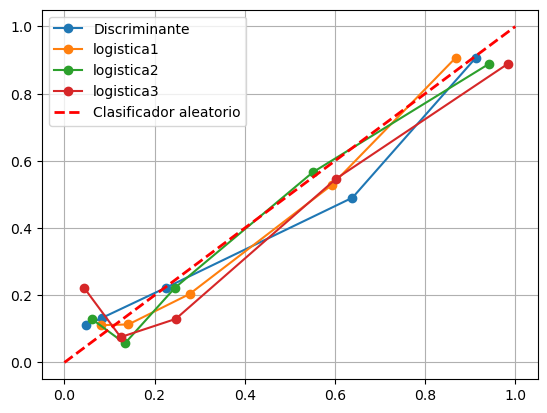

In [29]:
## Grafico de modelos
plt.plot(grouped_dis.probabilidades_dis, grouped_dis.real, marker = "o", label = "Discriminante")
plt.plot(grouped_log1.logistica1, grouped_log1.real, marker = "o", label = "logistica1")
plt.plot(grouped_log2.logistica2, grouped_log2.real, marker = "o", label = "logistica2")
plt.plot(grouped_log3.logistica3, grouped_log3.real, marker = "o", label = "logistica3")

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
plt.grid()


¿Cuál es mejor? Veamos la función de perdida en el conjunto de prueba

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

In [30]:
from sklearn.metrics import log_loss

Modelo logistico

In [31]:
log_loss(y_pred =juntar.logistica1, y_true = juntar.real)

0.443862189732074

Modelo polinomio 2

In [32]:
log_loss(y_pred =juntar.logistica2, y_true = juntar.real)

0.43500316656745175

Modelo polinomio 3

In [33]:
log_loss(y_pred =juntar.logistica3, y_true = juntar.real)

0.6812149627126901

Modelo discriminante

In [34]:
log_loss(y_pred=calibracion.modelo_discriminante_lineal, y_true=calibracion.real)

NameError: name 'calibracion' is not defined

#### Histogramas

In [ ]:
plt.hist(juntar.query("real == 1").logistica1, density=True, alpha = 0.5)
plt.hist(juntar.query("real == 0").logistica1, density=True, alpha = 0.5)
plt.show()


In [ ]:
plt.hist(real1.modelo_lineal, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_lineal, density=True, alpha=0.5, bins=10)
plt.show()

In [ ]:
plt.hist(real1.modelo_cuadratico, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_cuadratico, density=True, alpha=0.5, bins=10)
plt.show()

In [ ]:
plt.hist(real1.modelo_cubico, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_cubico, density=True, alpha=0.5, bins=10)
plt.show()

In [ ]:
plt.hist(real1.modelo_discriminante_lineal, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_discriminante_lineal, density=True, alpha=0.5, bins=10)
plt.show()